Deep Learning (MXNET) LSTM


In [25]:
import numpy as np
import pandas as pd
import json
from datetime import datetime
from dateutil.parser import parse
import sys
sys.path.append('../')
from mlalgms.statsmodel import calculateHistoricalParameters

In [26]:
anomaly_data = pd.read_csv("../../test_data/timeserials2.csv")
print(type(anomaly_data))
### print size
print(anomaly_data.shape)
### print columns
print(anomaly_data.columns.values)

<class 'pandas.core.frame.DataFrame'>
(4032, 2)
['timestamp' 'value']


In [27]:
from mlalgms.statsmodel import detectAnomalies
from utils.converterutils import addHeader

In [28]:

idx = anomaly_data.timestamp.values
anomaly_data_ds = [parse(d) for d in idx ]
y = anomaly_data.value.values
df = addHeader (anomaly_data_ds, y)


In [29]:
from mlalgms.deeplearning import L, ctx
from mlalgms.deeplearning import createModel, trainModel, load_and_predict,calculateUpperLowerBound
from mlalgms.deeplearning import evaluate_accuracy,load

In [30]:
model, trainer = createModel(ctx, 1, 25, 0.001)
print(model)

Sequential(
  (0): LSTM(None -> 25, TNC, dropout=0.35)
  (1): LSTM(None -> 1, TNC)
)


In [31]:
from mlalgms.evaluator import ts_train_test_split


In [69]:
train_data_selected, test_data_selected  = ts_train_test_split(df, split_ratio=0.7)
print(len(test_data_selected) )
print(len(train_data_selected))
print(len(df))



1210
2822
4032


In [70]:
train = train_data_selected['y'].as_matrix().astype(np.float32)
test= test_data_selected ['y'].as_matrix().astype(np.float32)
all = df ['y'].as_matrix().astype(np.float32)
print(len(all))

4032


In [71]:
batch_size = 128
train_loader= load(train,batch_size)
test_loader = load(train, batch_size)

In [72]:
train_mse, test_mse= trainModel(train_loader, test_loader, model,trainer, ctx, 1,1,25,batch_size)
    
print(train_mse)


 #   upper = calculateThreshold(train_predicted , 2)

[0.0008844449122356625, 0.000881333548497186, 0.00087960824432388, 0.0008805356872313574, 0.0008849049322041378, 0.0008851769328074348, 0.0008674542219998091, 0.0008540460899973328, 0.0008503198840354224, 0.000845340982461652, 0.0008411531221297435, 0.0008376034000558202, 0.0008355882657823436, 0.000836718984868165, 0.00084358334029473, 0.0008498889621240898, 0.0008200977657827974, 0.0007929092732766826, 0.0007864557631799709, 0.0007789822057415933, 0.0007708602052330008, 0.0007626150440362674, 0.000753886715281861, 0.0007447936133520788, 0.0007353049779498101]


In [73]:
print(test_mse)

[0.0008844449122356625, 0.000881333548497186, 0.00087960824432388, 0.0008805356872313574, 0.0008849049322041378, 0.0008851769328074348, 0.0008674542219998091, 0.0008540460899973328, 0.0008503198840354224, 0.000845340982461652, 0.0008411531221297435, 0.0008376034000558202, 0.0008355882657823436, 0.000836718984868165, 0.00084358334029473, 0.0008498889621240898, 0.0008200977657827974, 0.0007929092732766826, 0.0007864557631799709, 0.0007789822057415933, 0.0007708602052330008, 0.0007626150440362674, 0.000753886715281861, 0.0007447936133520788, 0.0007353049779498101]


In [74]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(16, 7)

In [75]:


# Plot the training vs test mse
def plot_errors(train_mse, test_mse):
    epochs = range(len(train_mse))
    figsize(16, 7)
    plt.plot(epochs, train_mse, label='Train')
    plt.plot(epochs, test_mse, label='Test')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

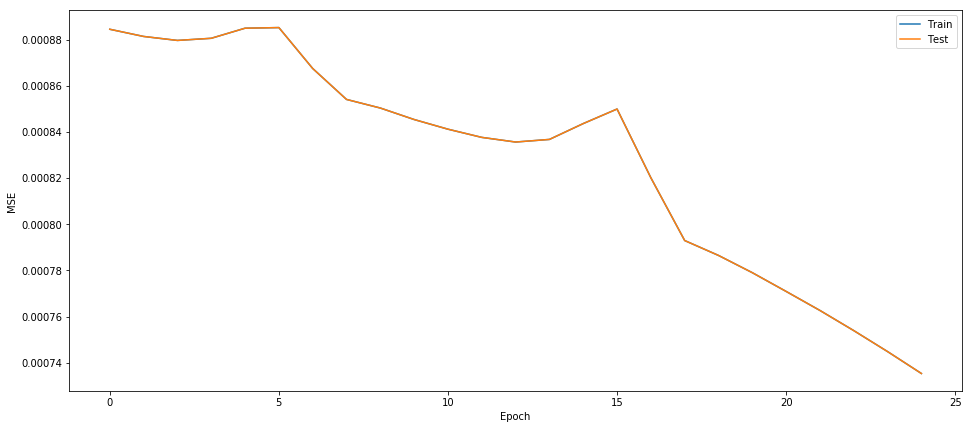

In [76]:
plot_errors(train_mse, test_mse)

In [78]:
tall= load_and_predict(all,L, model, batch_size,1)

print(len(tall))
    

4032


In [79]:
upper, lower = calculateUpperLowerBound(tall , 3)

In [80]:
print(tall, upper)

[5.38194843e-04 9.77956443e-05 6.36319746e-05 ... 3.56931878e-06
 3.96603764e-06 4.02057185e-06] 0.06304955304269821


In [81]:
print(upper,'  , ', lower)

0.06304955304269821   ,  -0.06097038540142673


In [82]:
anomaly = list(map(lambda v: v > upper, tall))

In [83]:
print(len(anomaly))

4032


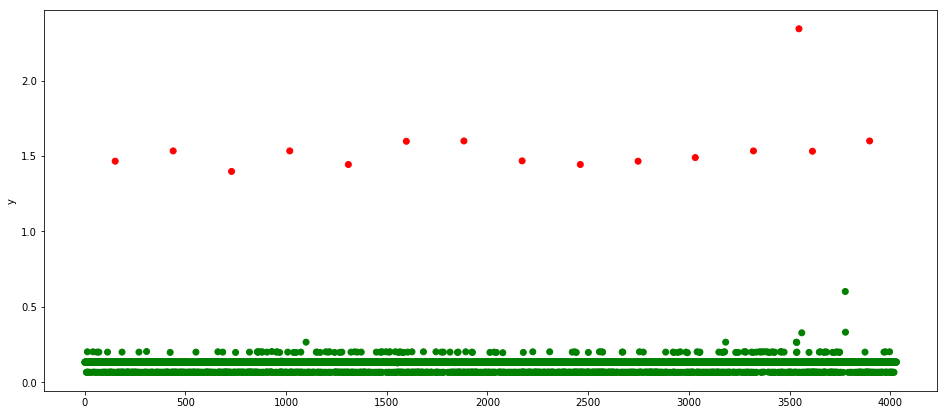

In [84]:
anomaly1 = list(map(lambda v: "red" if v else "green", anomaly))
figsize(16, 7)
plt.scatter(list(range(len(df['y']))),df['y'], c=anomaly1)
plt.ylabel('y')
plt.show()